# **Implement a Word embedding model and train your own word vectors using Co-Occurrence Matrix by applying Singular Value Decomposition (SVD).**

## IMPORTING LIBRARIES


In [1]:
import gzip
import shutil
from heapq import nlargest
from google.colab import drive
drive.mount('/content/drive')

import json, ast, re, os, nltk

nltk.download('punkt')
from operator import itemgetter
import operator
from keras.preprocessing.text import Tokenizer

import warnings
warnings.filterwarnings("ignore")
import pickle
from scipy.sparse import dok_matrix
from sklearn.utils.extmath import randomized_svd
from scipy import spatial
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import gensim.downloader

Mounted at /content/drive
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## GETTING DATA

In [6]:
def get_data():    
  with gzip.open('drive/MyDrive/reviews_Electronics_5.json.gz', 'rb') as f_in:
      with open('Electronics_5.json', 'wb') as f_out:
          shutil.copyfileobj(f_in, f_out)
  raw_text=[]

  f = open('Electronics_5.json',)

  for line in f:
    res = ast.literal_eval(line)
    raw_text.append(res["reviewText"].lower())

  f.close()
  return raw_text

In [7]:
raw_text = get_data()

In [8]:
os.remove("Electronics_5.json")

## PRE-PROCESSING DATA

In [9]:
def raw_text_to_sentences(raw_text):
  d={}
  word_count=1
  f= open("sentence_file.txt","x")
  f.close()
  f = open("sentence_file.txt","w" )
  for para in raw_text:
    nltk_tokens = nltk.sent_tokenize(para)
    for words in nltk_tokens:
      sent = re.findall("[A-Za-z]+", words)
      line = ""
      for word in sent:
        line = line + ' ' + word.lower()
        word_count+=1
        try:
            d[word.lower()] += 1
        except KeyError:
            d[word.lower()] = 1
      f.write(line)
      f.write("\n")
  f.close()
  return d,word_count

In [10]:
def remove_infrequent_words(d,n,xx):
  less_freq_word=0
  f = open("sentence_file.txt", "r")
  lines = f.readlines()
  no_of_lines = len(lines)

  for i in range(no_of_lines):
    x=""
    words=lines[i].split()
    for word in words:
      try:
        if d[word]>n and d[word]<xx:
          x= x + ' ' + word
        else :
          less_freq_word+=1
      except Keyerror:
        pass
    lines[i] = x + "\n"

  f = open("sentence_file.txt", "w")
  f.writelines(lines)
  f.close()
  return


reviews to good data  - in sentence_file.txt
1. just sentences with words..no punctuations
2. returns count of total words present
3. returns dictionary

In [11]:
count_dictionary, word_count = raw_text_to_sentences(raw_text)

In [12]:
del raw_text

In [13]:
d= dict(sorted(count_dictionary.items(), key = itemgetter(1), reverse = True)[:50])
xx = min(d.values())

In [14]:
del d

In [15]:
remove_infrequent_words(count_dictionary,5,xx)

In [12]:
file = open("sentence_file.txt","r")
Counter = 0
Content = file.read()
CoList = Content.split("\n")
  
for i in CoList:
    if i:
        Counter += 1
          
print("This is the number of lines in the file")
print(Counter)
file.close()

This is the number of lines in the file
10298912


## CREATING VOCAB

In [16]:
f = open("sentence_file.txt", "r")
lines = f.readlines()
f.close()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines) #updating internal vocabulary based on a list of texts.

word_to_index = tokenizer.word_index # assigning indexes to words
vocab_length = len(word_to_index)

index_to_words = {}    # assigning words to indexes
for k,v in word_to_index.items():
  index_to_words[v] = k

## CREATE SPARSE MATRIX (USED DOK MATRIX)

In [15]:
from keras.preprocessing import sequence
def create_sparse_matrix(data):
  d={}
  for line in data:
    line = line[:-1]
    words=line.split()
    no_of_words = len(words)
    index=0
    for word in words:
      k=word_to_index[word]
      start = index - 2
      end = index + 2
      for i in range(start,end+1):
        if 0<=i<index or index<i<no_of_words:
          try:
            d[k,word_to_index[words[i]]]+=1
          except KeyError:
            d[k,word_to_index[words[i]]] = 1      
      index=index+1
  return d

In [16]:
matrix_dict = create_sparse_matrix(lines)

In [17]:
del lines

In [18]:
matrix1 = dok_matrix((vocab_length+1, vocab_length+1))
for k,v in matrix_dict.keys():
  matrix1[k,v]=matrix_dict[k,v]
del matrix_dict

## SVD CALL

In [19]:
u, s_matrix, vt_matrix = randomized_svd(matrix1, n_components = 100)

In [20]:
del s_matrix
del vt_matrix

In [21]:
loc = '/content/drive/MyDrive/weight_matrix_q1.pkl'
with open(loc,'wb') as f:
 pickle.dump(u, f)

In [2]:
loc = '/content/drive/MyDrive/weight_matrix_q1.pkl'
infile = open(loc,'rb')
u = pickle.load(infile)

## COSINE SIMILARITY

In [3]:
#csine dist for 60th row with other rows..jo top min/max distance - choose that

def cosine_similarity(v1,v2):
  result = 1 - spatial.distance.cosine(v1, v2)
  return result

## Display the top-10 word vectors for 5 different words (a combination of nouns, verbs, adjectives etc) using the above pre-trained models (1,2) using t-SNE (or such methods).

In [4]:
words = ["husband","shipping","truck","road","beautiful"]

Top 10 closest words for : husband
wife
girlfriend
boyfriend
fiancee
hubby
fiance
mom
dad
sister
father
---------------------------------------



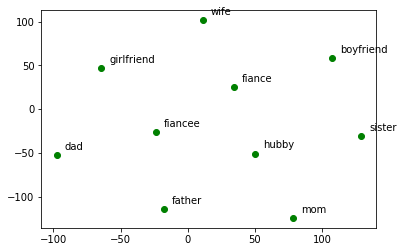

In [20]:
word = "husband"
dist_matrix={}
x=word_to_index[word]
dist_matrix[x]=0

embedings=[]
top_words=[]
for i in range(1,70685):  
  if i!=x:
    dist_matrix[i] = cosine_similarity(u[i],u[x])

TenHighest = nlargest(10, dist_matrix, key = dist_matrix.get)
print("Top 10 closest words for : ", end = word)
print()
for val in TenHighest:
  print(index_to_words[val])
  embedings.append(u[val])
  top_words.append(index_to_words[val])
print("---------------------------------------")
print()
tsne=TSNE()
tsne_list =tsne.fit_transform(embedings)
#plotting tsne graph

x_coord , y_coord = [] , []

tsne_list_size = len(tsne_list) 
for i in range(0,tsne_list_size):
  x_coord.append(tsne_list[i][0])
  y_coord.append(tsne_list[i][1])
plt.scatter(x_coord, y_coord, c ="green")

for i in range(0,tsne_list_size):
  plt.annotate(top_words[i], (x_coord[i]+6,y_coord[i]+6))

Top 10 closest words for : shipping
tax
delivery
shipment
supersaver
eligible
expedited
manufacturerpayment
membership
mear
delievery
---------------------------------------



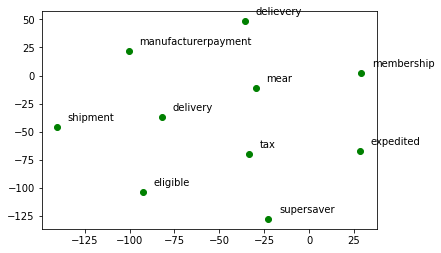

In [19]:
word = "shipping"
dist_matrix={}
x=word_to_index[word]
dist_matrix[x]=0

embedings=[]
top_words=[]
for i in range(1,70685):  
  if i!=x:
    dist_matrix[i] = cosine_similarity(u[i],u[x])

TenHighest = nlargest(10, dist_matrix, key = dist_matrix.get)
print("Top 10 closest words for : ", end = word)
print()
for val in TenHighest:
  print(index_to_words[val])
  embedings.append(u[val])
  top_words.append(index_to_words[val])
print("---------------------------------------")
print()
tsne=TSNE()
tsne_list =tsne.fit_transform(embedings)
#plotting tsne graph

x_coord , y_coord = [] , []

tsne_list_size = len(tsne_list) 
for i in range(0,tsne_list_size):
  x_coord.append(tsne_list[i][0])
  y_coord.append(tsne_list[i][1])
plt.scatter(x_coord, y_coord, c ="green")

for i in range(0,tsne_list_size):
  plt.annotate(top_words[i], (x_coord[i]+6,y_coord[i]+6))

Top 10 closest words for : truck
van
minivan
suv
garage
dog
dash
boat
jeep
motorcycle
bike
---------------------------------------



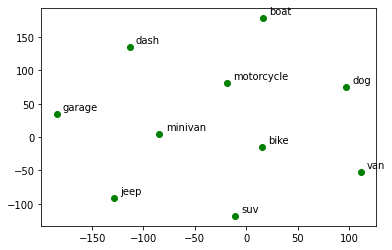

In [21]:
word = "truck"
dist_matrix={}
x=word_to_index[word]
dist_matrix[x]=0

embedings=[]
top_words=[]
for i in range(1,70685):  
  if i!=x:
    dist_matrix[i] = cosine_similarity(u[i],u[x])

TenHighest = nlargest(10, dist_matrix, key = dist_matrix.get)
print("Top 10 closest words for : ", end = word)
print()
for val in TenHighest:
  print(index_to_words[val])
  embedings.append(u[val])
  top_words.append(index_to_words[val])
print("---------------------------------------")
print()
tsne=TSNE()
tsne_list =tsne.fit_transform(embedings)
#plotting tsne graph

x_coord , y_coord = [] , []

tsne_list_size = len(tsne_list) 
for i in range(0,tsne_list_size):
  x_coord.append(tsne_list[i][0])
  y_coord.append(tsne_list[i][1])
plt.scatter(x_coord, y_coord, c ="green")

for i in range(0,tsne_list_size):
  plt.annotate(top_words[i], (x_coord[i]+6,y_coord[i]+6))

Top 10 closest words for : road
highway
interstate
freeway
bouncing
goofing
bounced
flying
shutting
skidding
ramp
---------------------------------------



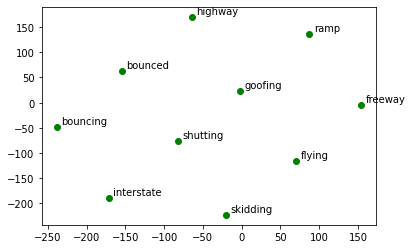

In [22]:
word = "road"
dist_matrix={}
x=word_to_index[word]
dist_matrix[x]=0

embedings=[]
top_words=[]
for i in range(1,70685):  
  if i!=x:
    dist_matrix[i] = cosine_similarity(u[i],u[x])

TenHighest = nlargest(10, dist_matrix, key = dist_matrix.get)
print("Top 10 closest words for : ", end = word)
print()
for val in TenHighest:
  print(index_to_words[val])
  embedings.append(u[val])
  top_words.append(index_to_words[val])
print("---------------------------------------")
print()
tsne=TSNE()
tsne_list =tsne.fit_transform(embedings)
#plotting tsne graph

x_coord , y_coord = [] , []

tsne_list_size = len(tsne_list) 
for i in range(0,tsne_list_size):
  x_coord.append(tsne_list[i][0])
  y_coord.append(tsne_list[i][1])
plt.scatter(x_coord, y_coord, c ="green")

for i in range(0,tsne_list_size):
  plt.annotate(top_words[i], (x_coord[i]+6,y_coord[i]+6))

Top 10 closest words for : beautiful
gorgeous
brilliant
lovely
matted
beatiful
vivid
colorful
vibrant
vibrancy
stunning
---------------------------------------



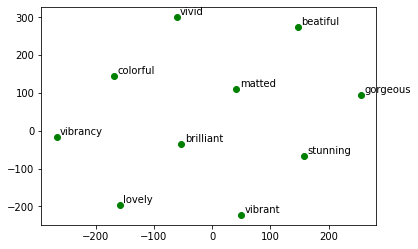

In [23]:
word = "beautiful"
dist_matrix={}
x=word_to_index[word]
dist_matrix[x]=0

embedings=[]
top_words=[]
for i in range(1,70685):  
  if i!=x:
    dist_matrix[i] = cosine_similarity(u[i],u[x])

TenHighest = nlargest(10, dist_matrix, key = dist_matrix.get)
print("Top 10 closest words for : ", end = word)
print()
for val in TenHighest:
  print(index_to_words[val])
  embedings.append(u[val])
  top_words.append(index_to_words[val])
print("---------------------------------------")
print()
tsne=TSNE()
tsne_list =tsne.fit_transform(embedings)
#plotting tsne graph

x_coord , y_coord = [] , []

tsne_list_size = len(tsne_list) 
for i in range(0,tsne_list_size):
  x_coord.append(tsne_list[i][0])
  y_coord.append(tsne_list[i][1])
plt.scatter(x_coord, y_coord, c ="green")

for i in range(0,tsne_list_size):
  plt.annotate(top_words[i], (x_coord[i]+6,y_coord[i]+6))

What are the top 10 closest words for the word ‘camera’ in the embeddings gen-
erated by your program. Compare them against the pre-trained word2vec embed-
dings that you can download off the shelf (can use gensim).

In [24]:
dist_matrix={}
x=word_to_index['camera']
dist_matrix[x]=0

for i in range(1,70685):  
  if i!=x:
    dist_matrix[i] = cosine_similarity(u[i],u[x])

from heapq import nlargest
TenHighest = nlargest(10, dist_matrix, key = dist_matrix.get)
print("Top 10 closest words for 'camera' :")
for val in TenHighest:
    #print(val)
    print(index_to_words[val])

Top 10 closest words for 'camera' :
camerasto
camerasfor
camerasand
camerason
camara
cameraswhich
mywestern
camerasi
thewestern
btar


In [ ]:

word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')
word2vec_vectors.most_similar('camera')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
word2vec_vectors.most_similar('camera')

[('cameras', 0.8131939172744751),
 ('Wagging_finger', 0.7311819791793823),
 ('camera_lens', 0.7250816822052002),
 ('camcorder', 0.7037474513053894),
 ('Camera', 0.6848659515380859),
 ('Canon_digital_SLR', 0.6474252939224243),
 ('Cameras', 0.6350969076156616),
 ('Nikon_D####_digital_SLR', 0.6259366273880005),
 ('tripod', 0.6189837455749512),
 ('EyeToy_USB', 0.6173486709594727)]

comparison btw the two : the words are not the same, but the words predicted by word emebedding model using svd still returns words similar to the target word "camera"